# DTMのコードの関数作成
* time_sliceの作成
 * 年月別ユーザー数でtime_sliceを作成する
* 上記で作成した年月別ユーザー数をリスト化する
* corpus作成のデータ準備
 * ユーザーの年月別購買商品を取得する
 * リスト化
 * ※ここで、ユーザーIDとユーザーの購買履歴を対応づける作業を行う。
* DTMのデータ準備
 * cat4の辞書の作成
 * corpus作成
* DTM実装
 * トピック数を指定する
 * モデルを実行し、モデルを保存する
* DTM結果の可視化
 * 各トピックの年月別割合推移を可視化する
 * サンキーダイアグラムを用いて


In [1]:
pip install japanize-matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt

In [3]:
target_data_food = pd.read_csv("super_cat1_food_data_target_user10_2500.csv", index_col=0)

In [4]:
#日付データの形式変更
target_data_food['receipt_buydate'] = pd.to_datetime(target_data_food['receipt_buydate'])

In [5]:
pip install gensim nltk

Note: you may need to restart the kernel to use updated packages.


# classを使ってdtmの前処理を記述

In [6]:
from gensim import corpora, models
import pandas as pd

class Pre_dtm:
    def __init__(self, target_data_food):
        self.target_data_food = target_data_food
        self.user_time_slice = None
        self.user_cat4_ym = None
        self.indices_by_id = None
        self.dictionary = None
        self.corpus = None

    def create_time_slice(self):
        unique_user_count = self.target_data_food.groupby(self.target_data_food['receipt_buydate'].dt.to_period("M"))['id'].nunique().reset_index()
        unique_user_count.columns = ['receipt_buydate', 'unique_user_count']
        self.user_time_slice = unique_user_count['unique_user_count'].tolist()
        return self.user_time_slice

    def prepare_corpus_data(self):
        grouped_cat4_data = self.target_data_food.groupby([self.target_data_food['receipt_buydate'].dt.to_period("M"), 'id'])['cat4'].apply(lambda x: [product.strip() for product in x]).reset_index()
        self.user_cat4_ym = grouped_cat4_data['cat4'].tolist()
        date_range = pd.date_range(start='2014-04-01', end='2015-03-31', freq='M').strftime('%Y-%m').tolist()
        self.indices_by_id = grouped_cat4_data.groupby('id').apply(lambda group: [group[group['receipt_buydate'].dt.strftime('%Y-%m') == month].index[0].tolist() if month in group['receipt_buydate'].dt.strftime('%Y-%m').tolist() else 'NA' for month in date_range])

        return self.user_cat4_ym, self.indices_by_id

    def create_dictionary(self):
        texts = self.target_data_food['cat4'].tolist()
        processed_docs = [[str(doc).lower().strip()] for doc in texts]
        self.dictionary = corpora.Dictionary(processed_docs)
        return self.dictionary

    def create_corpus(self):
        if self.dictionary is None:
            self.create_dictionary()
        if self.user_cat4_ym is None:
            self.prepare_corpus_data()
        self.corpus = [self.dictionary.doc2bow(doc) for doc in self.user_cat4_ym]
        return self.corpus

    def analyze(self):
        self.create_time_slice()
        self.prepare_corpus_data()
        self.create_dictionary()
        self.create_corpus()
        return {
            'time_slice': self.user_time_slice,
            'corpus_data': (self.user_cat4_ym, self.indices_by_id),
            'dictionary': self.dictionary,
            'corpus': self.corpus
        }

In [7]:
# Assuming you have your target_data_food DataFrame
analyzer = Pre_dtm(target_data_food)
results = analyzer.analyze()

# Access the results
user_time_slice = results['time_slice']
user_cat4_ym, indices_by_id = results['corpus_data']
dictionary = results['dictionary']
corpus = results['corpus']

In [15]:
user_time_slice = results['time_slice']

In [9]:
user_time_slice

[16939,
 16953,
 16942,
 16953,
 16958,
 16948,
 16954,
 16927,
 16940,
 16922,
 16905,
 16929]

# DTM実装

In [13]:
from gensim.models import LdaSeqModel
import numpy as np
import datetime

# トピック数を指定,データのタイプを指定
num_topics = 10
data_type = 'super'
def run_dtm(num_topics, user_time_slice, corpus, dictionary):
    ldaseq = LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=user_time_slice, num_topics=num_topics)
    ldaseq.save(f'dtm_cat4_{num_topics}_{data_type}.pkl')


def vis_dtm_result(user_time_slice, num_topic, data_type):
    #各トピックの年月別割合推移を可視化する
    cumulative_list = [sum(user_time_slice[:i+1]) for i in range(len(user_time_slice))]
    #モデルの読み込み
    ldaseq = LdaSeqModel.load(f'dtm_cat4_{num_topics}_{data_type}.pkl')
    # トピックの割合を計算
    time_topic_prob = {}
    start = 0
    for num, index in enumerate(cumulative_list):
        # 各トピックの確率を効率的に平均化
        topic_probs = np.mean(ldaseq.doc_topics(range(start,index)), axis = 0)

        # 結果を格納
        time_topic_prob[num] = topic_probs

        # 次の時間帯の開始点を更新
        start = index
    #可視化の際のインデックスを取得
    times_ = list(target_data_food['receipt_buydate'].dt.to_period("M").unique())
    times_ = [str(str_time) for str_time in times_]
    times_ = sorted(times_, key=lambda x: datetime.datetime.strptime(x, "%Y-%m"))

    # データの準備
    data = time_topic_prob
    # データを時間とトピック別に整理
    times = list(data.keys())
    topic_prob_data = [[data[t][s] for t in times] for s in range(num_topic)]
    for i in range(num_topic):
        plt.plot(times_, topic_prob_data[i],label=f'Topic{i}')
    # グラフのスタイリング
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Topic Proportion', fontsize=12)
    plt.title('Topic Evolution Over Time', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    # plt.legend(loc='upper right')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{data_type}propotion.png", dpi=700)
    plt.show()
    print(topic_prob_data)
    print(data)

In [23]:
run_dtm(num_topics, user_time_slice, corpus, dictionary)

KeyboardInterrupt: 

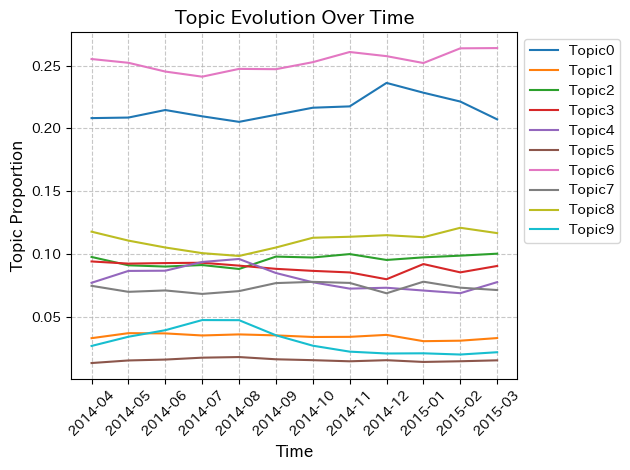

[[0.20825283758814447, 0.2086959484238559, 0.21470058144658796, 0.20969463098245206, 0.20528455576217972, 0.2108856048702566, 0.21652042150665488, 0.21757197988832003, 0.23623963135380516, 0.22845907875082133, 0.22142684237125815, 0.20726330739431217], [0.03333030120390289, 0.037306716699884786, 0.03711990346392489, 0.03547619130374197, 0.036330427378761354, 0.035542235809758065, 0.0342735861455685, 0.03437872281211981, 0.03595102025373665, 0.0309403644092586, 0.03132768235883584, 0.03341332177082482], [0.09788800557009025, 0.09125968627130514, 0.09026025534629452, 0.09145827526390983, 0.08833859851965506, 0.09816878290707005, 0.09745773669936825, 0.10017330850825262, 0.09549887004237648, 0.0975754412091153, 0.09892809410626095, 0.10049730949082303], [0.09431454254017127, 0.0925938534396829, 0.09302157620458905, 0.0932822563390754, 0.09099389194903944, 0.08844634629588115, 0.08682745207250116, 0.0855933096003173, 0.08017053965750948, 0.09223858452488343, 0.08563617051982673, 0.09072334

In [16]:
vis_dtm_result(user_time_slice, num_topics, data_type)

In [11]:
ldaseq = LdaSeqModel.load('dtm_cat4_10_super.pkl')
#時系列でのトピックの確率を取得
user_time_slice = 12
tmp_dic = {}
for time in range(user_time_slice):
    topics_at_time_t = ldaseq.print_topics(time=time)
    for topic_id, topic_prob in enumerate(topics_at_time_t):
        print(topic_id, topic_prob[0:5])
        tmp_dic[topic_id] = topic_prob[0:5]
pd.DataFrame(tmp_dic)

0 [('豆腐類', 0.13122968258771386), ('漬物', 0.05693833100534212), ('生麺・ゆで麺', 0.055598277290662065), ('納豆', 0.05418875800888947), ('煎餅・あられ', 0.03495012847584816)]
1 [('ビ－ル', 0.46402919249902363), ('ミネラルウォ－タ類', 0.0700808982138283), ('焼酎', 0.06476120827424173), ('ワイン', 0.061603428170021256), ('つまみ類', 0.053244432281669224)]
2 [('菓子パン・調理パン', 0.6460456000867213), ('食パン', 0.09940318835343308), ('牛乳', 0.04363395730038889), ('生麺・ゆで麺', 0.014033982030758563), ('ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺', 0.013186788586128546)]
3 [('ヨ－グルト', 0.29997266304076803), ('デザ－ト類', 0.08613643383007061), ('牛乳', 0.06538083364198066), ('野菜ジユ－ス', 0.06430396651571801), ('乳酸菌飲料', 0.050295400383911976)]
4 [('ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺', 0.19543206411717878), ('液体茶', 0.12401716294937806), ('コ－ヒ－ドリンク', 0.10044446243890909), ('炭酸飲料', 0.08658193794822587), ('コ－ラ', 0.05558497406579734)]
5 [('その他酒類', 0.8252556552662558), ('スナック', 0.032979879196258804), ('焼酎', 0.02717563697872814), ('炭酸飲料', 0.022539545796792036), ('ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺', 0.01508427083535206)]
6 [('食パン', 0.12213

,0,1,2,3,4,5,6,7,8,9
0,"(豆腐類, 0.12903819169931868)","(ビ－ル, 0.4835973968393817)","(菓子パン・調理パン, 0.6474545228302484)","(ヨ－グルト, 0.3359826911060177)","(ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺, 0.2212087349034706)","(その他酒類, 0.8364683491982022)","(食パン, 0.10890055258678402)","(冷凍調理, 0.5149727484086595)","(スナック, 0.2172633519923239)","(アイスクリ－ム, 0.8911725967052488)"
1,"(漬物, 0.05535642314508369)","(焼酎, 0.07207539431973184)","(食パン, 0.08509409159894023)","(デザ－ト類, 0.06163551922623068)","(液体茶, 0.11803094683844496)","(スナック, 0.027892595439721665)","(牛乳, 0.09238734492103723)","(ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺, 0.04213304817049562)","(チョコレ－ト, 0.1466511267612494)","(デザ－ト類, 0.024713223411366978)"
2,"(生麺・ゆで麺, 0.05354435727355431)","(ミネラルウォ－タ類, 0.06853042320513689)","(牛乳, 0.03666756275339253)","(野菜ジユ－ス, 0.05914259277945391)","(コ－ヒ－ドリンク, 0.09796001657906571)","(焼酎, 0.022192939117864862)","(豆腐類, 0.05675887363448421)","(冷凍農産, 0.035841323161682793)","(ﾋﾞｽｹﾂﾄ&ｸﾗﾂｶ-, 0.12187825824937461)","(炭酸飲料, 0.01323020132993344)"
3,"(納豆, 0.048529723478424526)","(ワイン, 0.06492175819469027)","(生麺・ゆで麺, 0.01568263964320287)","(牛乳, 0.05880672427497138)","(炭酸飲料, 0.08808322959998639)","(ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺, 0.01773175351038224)","(チ－ズ, 0.04205991812309197)","(洋風食品, 0.034897569501285176)","(煎餅・あられ, 0.10261821817416404)","(コ－ラ, 0.00879719758502751)"
4,"(揚げ物, 0.03562943732819765)","(日本酒, 0.04497358468792214)","(その他菓子, 0.01508054660577848)","(納豆, 0.05251512796186848)","(コ－ラ, 0.054415024025051106)","(炭酸飲料, 0.013891426385364827)","(生麺・ゆで麺, 0.036366203727664116)","(畜肉ソ－セ－ジ, 0.03138929436048753)","(キャンディ, 0.08079097296408201)","(サイダ－, 0.007241430853163754)"


In [17]:
# 年月リスト（例: 2014年4月～2015年3月）
time_labels = pd.date_range(start="2014-04-01", end="2015-03-01", freq="MS").strftime("%Y-%m").tolist()

# 検証用: 出力する全データを保持するリスト
all_rows = []

# トピックデータの処理とラベル付け
for time, label in enumerate(time_labels):
    topics_at_time_t = ldaseq.print_topics(time=time)  # 各タイムスライスのトピックを取得
    rows = []
    for topic_id, topic in enumerate(topics_at_time_t):
        # トピックごとのデータ整形
        row = {"年月": label, "トピック": topic_id}
        for rank, (word, prob) in enumerate(topic[:5], start=1):  # 上位5つを取得
            row[f"{rank} 位"] = f"{word} ({prob:.3f})"
        rows.append(row)
    all_rows.extend(rows)  # 全タイムスライスのデータをまとめる

# データフレーム化
df = pd.DataFrame(all_rows)
output_file = "dtm_topic/dtm_topic_super.csv"
df.to_csv(output_file, index=False, encoding="utf-8-sig")

# サンキーダイアグラムの可視化

In [18]:
from collections import defaultdict
import numpy as np

def analyze_cluster_transitions(indices_by_id, ldaseq):
    def create_user_cluster_dict(indices_by_id, ldaseq):
        # indices_by_id = pd.DataFrame(indices_by_id).reset_index()
        # indices_by_id.columns = ['id', 'doc_list']
        # user_cluster_dic = {}
        # for id, doc_list in zip(indices_by_id['id'], indices_by_id['doc_list']):
        #     clus_list = []
        #     num = 0
        #     for doc_num in doc_list:
        #         bel_ind = np.argmax(ldaseq.doc_topics(doc_num))
        #         clus_list.append(f'{bel_ind}_{num}')
        #         num += 1
        #     user_cluster_dic[id] = clus_list
        user_cluster_dic={}
        indices_by_id = pd.DataFrame(indices_by_id).reset_index()
        indices_by_id.columns = ['id', 'doc_list']
        for id, doc_list in zip(indices_by_id['id'], indices_by_id['doc_list']):
            clus_list = []
            num = 0
            for doc_num in doc_list:
                if doc_num == 'NA':
                    clus_list.append(f'{100}_{num}')
                else:
                    bel_ind = np.argmax(ldaseq.doc_topics(doc_num))
                    clus_list.append(f'{bel_ind}_{num}')
                num += 1
            user_cluster_dic[id] = clus_list
        return user_cluster_dic
        return user_cluster_dic

    def count_transitions(cluster_sequences):
        transition_counts = defaultdict(int)
        for cluster_sequence in cluster_sequences:
            for i in range(len(cluster_sequence) - 1):
                current_cluster = cluster_sequence[i]
                next_cluster = cluster_sequence[i + 1]
                transition = (current_cluster, next_cluster)
                transition_counts[transition] += 1
        return transition_counts

    def prepare_sankey_data(transition_counts):
        source = []
        target = []
        values_list = []
        for item, value in transition_counts.items():
            source.append(item[0])
            target.append(item[1])
            values_list.append(value)
        return source, target, values_list

    user_cluster_dic = create_user_cluster_dict(indices_by_id, ldaseq)
    cluster_sequences = user_cluster_dic.values()
    transition_counts = count_transitions(cluster_sequences)

    # 結果の出力
    for transition, count in transition_counts.items():
        print(f"遷移 {transition} は {count} 回発生しました。")

    source, target, values_list = prepare_sankey_data(transition_counts)

    return user_cluster_dic, transition_counts, source, target, values_list


In [19]:
# indices_by_id と ldaseq が既に定義されていると仮定
user_cluster_dic, transition_counts, source, target, values_list = analyze_cluster_transitions(indices_by_id, ldaseq)

# 返された値を使って後続の処理を行う
# 例: サンキーダイアグラムの作成など

遷移 ('0_0', '0_1') は 3055 回発生しました。
遷移 ('0_1', '0_2') は 3183 回発生しました。
遷移 ('0_2', '0_3') は 3274 回発生しました。
遷移 ('0_3', '0_4') は 3121 回発生しました。
遷移 ('0_4', '0_5') は 3053 回発生しました。
遷移 ('0_5', '0_6') は 3162 回発生しました。
遷移 ('0_6', '0_7') は 3200 回発生しました。
遷移 ('0_7', '0_8') は 3391 回発生しました。
遷移 ('0_8', '0_9') は 3445 回発生しました。
遷移 ('0_9', '6_10') は 1176 回発生しました。
遷移 ('6_10', '0_11') は 875 回発生しました。
遷移 ('2_0', '2_1') は 748 回発生しました。
遷移 ('2_1', '0_2') は 145 回発生しました。
遷移 ('0_4', '2_5') は 156 回発生しました。
遷移 ('2_5', '0_6') は 170 回発生しました。
遷移 ('0_6', '2_7') は 147 回発生しました。
遷移 ('2_7', '6_8') は 206 回発生しました。
遷移 ('6_8', '2_9') は 203 回発生しました。
遷移 ('2_9', '0_10') は 146 回発生しました。
遷移 ('0_10', '0_11') は 3050 回発生しました。
遷移 ('1_0', '100_1') は 13 回発生しました。
遷移 ('100_1', '2_2') は 5 回発生しました。
遷移 ('2_2', '7_3') は 24 回発生しました。
遷移 ('7_3', '4_4') は 30 回発生しました。
遷移 ('4_4', '4_5') は 566 回発生しました。
遷移 ('4_5', '0_6') は 104 回発生しました。
遷移 ('2_7', '1_8') は 7 回発生しました。
遷移 ('1_8', '2_9') は 7 回発生しました。
遷移 ('2_9', '2_10') は 766 回発生しました。
遷移 ('2_10', '1_11') は 5 回発生しまし

In [20]:
#遷移行列を作成するためのコード
transtion_data = []
for (from_state,to_state), count in transition_counts.items():
    cluster_f, time_f = from_state.split('_')
    cluster_t, time_t = to_state.split('_')
    if cluster_f == "100" and cluster_t == "100":
        from_state = f'10_{time_f}'
        to_state = f'10_{time_t}'
        transtion_data.append((from_state, to_state, count))
    elif cluster_f == "100":
        from_state = f'10_{time_f}'
        transtion_data.append((from_state, to_state, count))
    elif cluster_t == "100":
        to_state = f'10_{time_t}'
        transtion_data.append((from_state, to_state, count))
    else:
        transtion_data.append((from_state, to_state, count))

In [21]:
import pandas as pd
from collections import defaultdict

def create_time_dependent_transition_matrices(data):
    """
    時点ごとの遷移行列を作成する関数
    
    :param data: (from_state, to_state, count) の形式のデータリスト
    :return: 時点ごとの遷移行列を含む辞書
    """
    # クラスタと時点の情報を抽出
    all_clusters = set()
    all_timepoints = set()
    for from_state, to_state, _ in data:
        from_cluster, from_time = from_state.split('_')
        to_cluster, to_time = to_state.split('_')
        all_clusters.update([int(from_cluster), int(to_cluster)])
        all_timepoints.update([int(from_time), int(to_time)])
    
    num_clusters = 11
    num_timepoints = max(all_timepoints) + 1
    
    # 時点ごとの遷移回数を格納する辞書を初期化
    transition_counts = defaultdict(lambda: np.zeros((num_clusters, num_clusters)))
    
    # データから遷移回数を集計
    for from_state, to_state, count in data:
        from_cluster, from_time = map(int, from_state.split('_'))
        to_cluster, to_time = map(int, to_state.split('_'))
        if from_time + 1 == to_time:  # 連続する時点間の遷移のみを考慮
            transition_counts[from_time][from_cluster, to_cluster] += count
    
    # 遷移確率行列を計算
    transition_matrices = {}
    for time, counts in transition_counts.items():
        row_sums = counts.sum(axis=1)
        row_sums[row_sums == 0] = 1  # ゼロ除算を避ける
        transition_matrices[time] = counts / row_sums[:, np.newaxis]
    
    return transition_matrices


時点 0 から 1 への遷移行列:
各状態のエントロピー：[2.09951142 1.2197807  1.44826086 1.68288172 1.81117443 0.55399345
 2.14659644 1.4288661  1.94880498 1.03722647 1.04843821]

全体のエントロピー1.4932304356770623
      0     1     2     3     4     5     6     7     8     9     10
0  0.662 0.011 0.027 0.032 0.020 0.003 0.186 0.019 0.035 0.003 0.001
1  0.061 0.615 0.020 0.024 0.061 0.030 0.081 0.010 0.047 0.007 0.044
2  0.109 0.003 0.568 0.033 0.046 0.001 0.153 0.025 0.052 0.006 0.005
3  0.151 0.014 0.035 0.448 0.063 0.003 0.191 0.031 0.046 0.007 0.012
4  0.089 0.027 0.036 0.042 0.556 0.008 0.115 0.025 0.080 0.009 0.014
5  0.136 0.097 0.019 0.029 0.068 0.476 0.107 0.019 0.029 0.000 0.019
6  0.145 0.005 0.026 0.030 0.021 0.002 0.695 0.023 0.046 0.002 0.002
7  0.145 0.011 0.041 0.042 0.029 0.004 0.187 0.460 0.070 0.008 0.004
8  0.115 0.009 0.041 0.045 0.061 0.002 0.211 0.034 0.461 0.009 0.012
9  0.181 0.056 0.028 0.028 0.153 0.000 0.125 0.028 0.125 0.222 0.056
10 0.063 0.059 0.034 0.044 0.093 0.010 0.078 0.029 0.088 0

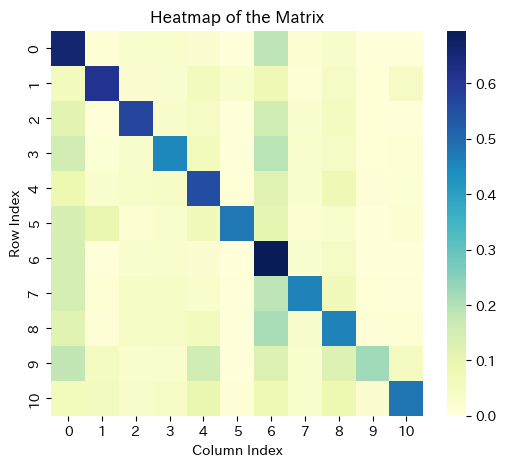


時点 1 から 2 への遷移行列:
各状態のエントロピー：[2.12150173 1.00120163 1.45570324 1.74540493 1.8657353  0.59849249
 2.13037042 1.42450385 1.84633522 1.046025   1.00181102]

全体のエントロピー1.4760986204819266
      0     1     2     3     4     5     6     7     8     9     10
0  0.677 0.005 0.021 0.032 0.021 0.003 0.181 0.024 0.031 0.003 0.003
1  0.166 0.490 0.017 0.025 0.090 0.034 0.085 0.008 0.042 0.008 0.034
2  0.119 0.002 0.568 0.031 0.048 0.004 0.144 0.025 0.048 0.007 0.004
3  0.168 0.009 0.032 0.437 0.049 0.002 0.202 0.027 0.053 0.012 0.009
4  0.095 0.016 0.040 0.044 0.532 0.012 0.122 0.027 0.073 0.018 0.020
5  0.094 0.038 0.038 0.066 0.113 0.538 0.047 0.019 0.028 0.009 0.009
6  0.152 0.007 0.028 0.030 0.018 0.002 0.694 0.025 0.038 0.004 0.003
7  0.138 0.008 0.035 0.043 0.040 0.003 0.171 0.497 0.060 0.003 0.003
8  0.137 0.010 0.042 0.039 0.052 0.004 0.193 0.025 0.468 0.017 0.013
9  0.100 0.011 0.033 0.056 0.111 0.000 0.167 0.056 0.056 0.333 0.078
10 0.079 0.042 0.026 0.021 0.099 0.016 0.094 0.031 0.058 0

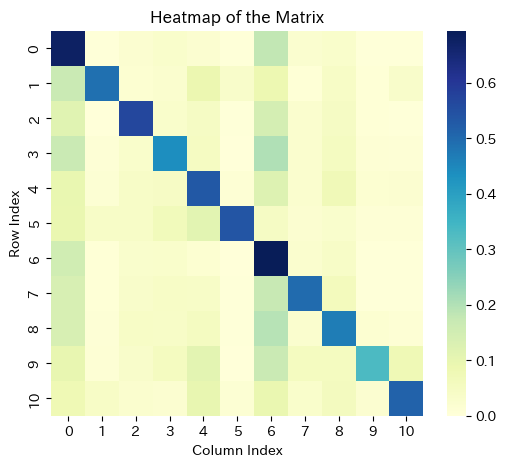


時点 2 から 3 への遷移行列:
各状態のエントロピー：[2.05963807 1.02001376 1.40962791 1.6992099  1.8425169  0.54398772
 2.13223009 1.49935289 1.92342703 0.96848024 0.91570999]

全体のエントロピー1.4558358645447766
      0     1     2     3     4     5     6     7     8     9     10
0  0.663 0.007 0.029 0.031 0.028 0.002 0.183 0.021 0.028 0.006 0.002
1  0.095 0.567 0.010 0.036 0.089 0.020 0.089 0.007 0.052 0.007 0.030
2  0.096 0.005 0.605 0.029 0.046 0.002 0.133 0.021 0.048 0.008 0.006
3  0.128 0.008 0.039 0.458 0.054 0.007 0.195 0.037 0.049 0.018 0.007
4  0.089 0.024 0.054 0.050 0.553 0.008 0.111 0.025 0.055 0.014 0.018
5  0.073 0.106 0.008 0.024 0.049 0.504 0.114 0.049 0.049 0.000 0.024
6  0.141 0.004 0.033 0.035 0.023 0.002 0.691 0.023 0.041 0.005 0.002
7  0.180 0.005 0.042 0.032 0.046 0.003 0.193 0.435 0.053 0.010 0.003
8  0.117 0.011 0.036 0.036 0.066 0.005 0.200 0.042 0.457 0.019 0.012
9  0.104 0.000 0.028 0.056 0.104 0.000 0.104 0.035 0.104 0.438 0.028
10 0.054 0.045 0.045 0.040 0.104 0.015 0.064 0.010 0.079 0

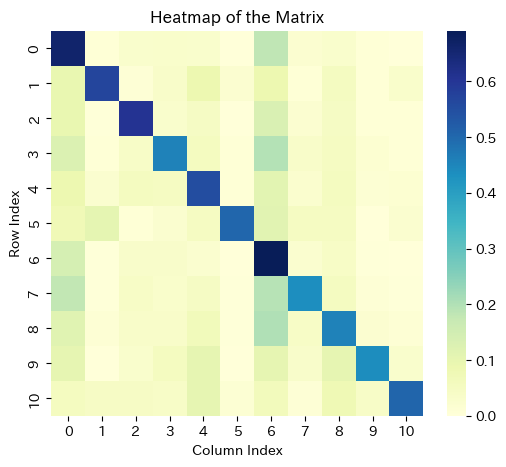


時点 3 から 4 への遷移行列:
各状態のエントロピー：[2.10164465 1.06910761 1.52323148 1.70851485 1.8750577  0.58842557
 2.17069685 1.38643822 1.92145653 0.86191224 0.89564009]

全体のエントロピー1.4638296175606629
      0     1     2     3     4     5     6     7     8     9     10
0  0.646 0.006 0.024 0.031 0.023 0.004 0.200 0.025 0.032 0.006 0.003
1  0.109 0.546 0.029 0.038 0.083 0.022 0.099 0.010 0.029 0.010 0.026
2  0.104 0.004 0.552 0.035 0.053 0.003 0.151 0.040 0.046 0.006 0.006
3  0.134 0.020 0.036 0.456 0.044 0.001 0.212 0.026 0.050 0.009 0.011
4  0.095 0.018 0.047 0.036 0.536 0.010 0.125 0.030 0.077 0.016 0.010
5  0.105 0.088 0.018 0.035 0.105 0.474 0.088 0.009 0.061 0.000 0.018
6  0.141 0.004 0.024 0.031 0.022 0.002 0.702 0.027 0.041 0.005 0.002
7  0.158 0.008 0.037 0.033 0.040 0.003 0.203 0.458 0.053 0.007 0.000
8  0.115 0.009 0.038 0.037 0.076 0.003 0.211 0.034 0.440 0.021 0.015
9  0.092 0.010 0.049 0.063 0.068 0.010 0.146 0.024 0.087 0.417 0.034
10 0.068 0.037 0.037 0.031 0.147 0.005 0.105 0.010 0.058 0

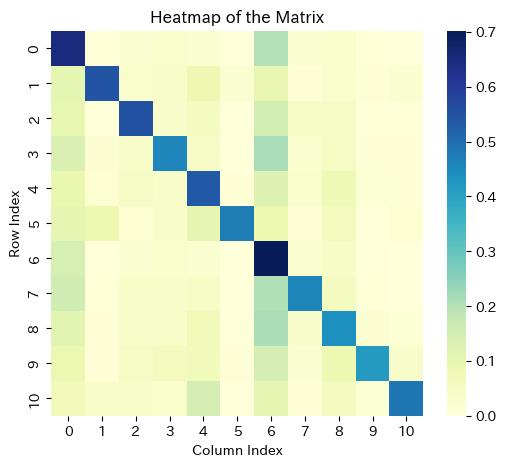


時点 4 から 5 への遷移行列:
各状態のエントロピー：[2.12226369 1.00883269 1.64878725 1.66102513 1.79721963 0.55775239
 2.15697738 1.74793049 1.91443393 0.99787562 0.922224  ]

全体のエントロピー1.5032111090302847
      0     1     2     3     4     5     6     7     8     9     10
0  0.651 0.007 0.033 0.028 0.021 0.002 0.188 0.029 0.036 0.002 0.004
1  0.085 0.550 0.016 0.023 0.078 0.033 0.085 0.036 0.049 0.010 0.036
2  0.117 0.005 0.608 0.032 0.031 0.001 0.129 0.027 0.037 0.006 0.007
3  0.147 0.009 0.050 0.433 0.041 0.001 0.218 0.035 0.054 0.008 0.005
4  0.111 0.021 0.068 0.051 0.485 0.007 0.119 0.042 0.068 0.006 0.021
5  0.120 0.077 0.034 0.017 0.085 0.496 0.068 0.051 0.034 0.000 0.017
6  0.152 0.005 0.037 0.032 0.016 0.002 0.676 0.032 0.042 0.003 0.002
7  0.149 0.009 0.051 0.028 0.030 0.004 0.210 0.458 0.048 0.006 0.008
8  0.126 0.003 0.052 0.038 0.056 0.002 0.209 0.049 0.447 0.008 0.010
9  0.151 0.005 0.078 0.060 0.046 0.009 0.161 0.060 0.161 0.252 0.018
10 0.054 0.048 0.043 0.027 0.108 0.005 0.097 0.038 0.059 0

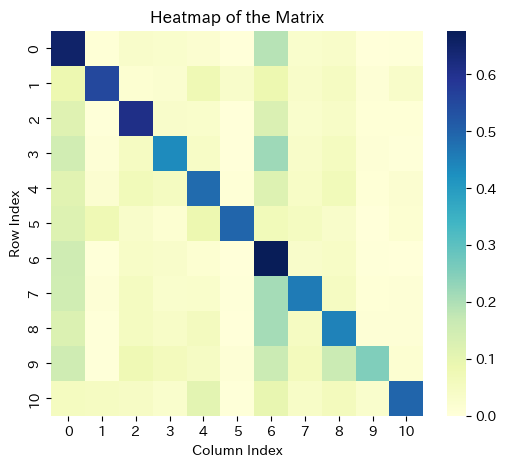


時点 5 から 6 への遷移行列:
各状態のエントロピー：[2.09814293 0.89076875 1.63523554 1.65930616 1.76433506 0.58200428
 2.17862597 1.551354   1.99809456 0.69169756 0.85522152]

全体のエントロピー1.4458896649678357
      0     1     2     3     4     5     6     7     8     9     10
0  0.662 0.006 0.025 0.025 0.014 0.001 0.198 0.030 0.034 0.002 0.003
1  0.100 0.547 0.040 0.030 0.070 0.037 0.093 0.023 0.047 0.000 0.013
2  0.126 0.001 0.563 0.027 0.042 0.004 0.138 0.024 0.063 0.002 0.009
3  0.153 0.006 0.052 0.425 0.041 0.004 0.209 0.042 0.059 0.001 0.006
4  0.104 0.017 0.061 0.033 0.497 0.007 0.126 0.033 0.095 0.009 0.017
5  0.093 0.074 0.019 0.009 0.046 0.556 0.083 0.019 0.074 0.009 0.019
6  0.169 0.003 0.031 0.027 0.012 0.002 0.678 0.026 0.047 0.001 0.003
7  0.131 0.007 0.042 0.019 0.036 0.002 0.209 0.476 0.072 0.004 0.001
8  0.118 0.009 0.050 0.036 0.041 0.003 0.196 0.041 0.485 0.007 0.013
9  0.107 0.000 0.061 0.107 0.107 0.000 0.160 0.038 0.122 0.275 0.023
10 0.056 0.036 0.036 0.051 0.092 0.020 0.112 0.026 0.082 0

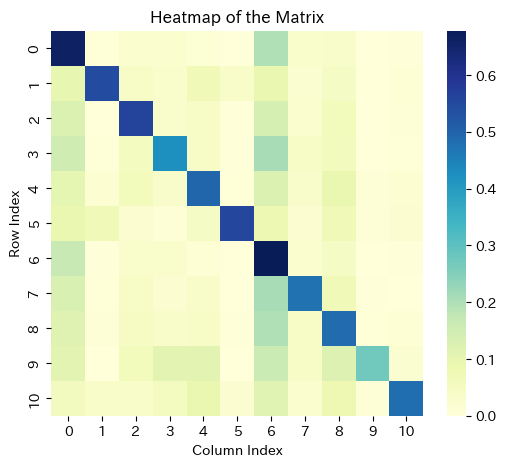


時点 6 から 7 への遷移行列:
各状態のエントロピー：[2.06250361 0.98606074 1.57001036 1.50977051 1.54284783 0.45122724
 2.18033115 1.50041908 1.99486081 0.58992343 1.00243066]

全体のエントロピー1.3991259476141318
      0     1     2     3     4     5     6     7     8     9     10
0  0.646 0.005 0.030 0.024 0.014 0.002 0.218 0.025 0.034 0.001 0.001
1  0.131 0.543 0.022 0.022 0.064 0.030 0.101 0.019 0.037 0.000 0.030
2  0.106 0.006 0.595 0.035 0.033 0.000 0.129 0.024 0.061 0.004 0.007
3  0.123 0.009 0.040 0.458 0.032 0.002 0.230 0.029 0.063 0.001 0.011
4  0.092 0.016 0.054 0.035 0.535 0.007 0.129 0.025 0.077 0.006 0.024
5  0.043 0.096 0.026 0.009 0.035 0.522 0.113 0.043 0.061 0.009 0.043
6  0.155 0.003 0.028 0.021 0.011 0.001 0.707 0.026 0.043 0.001 0.005
7  0.163 0.008 0.045 0.035 0.020 0.000 0.199 0.472 0.054 0.002 0.003
8  0.114 0.008 0.065 0.027 0.050 0.001 0.225 0.035 0.458 0.005 0.012
9  0.099 0.000 0.074 0.062 0.037 0.012 0.173 0.037 0.148 0.321 0.037
10 0.053 0.042 0.021 0.016 0.063 0.000 0.095 0.016 0.116 0

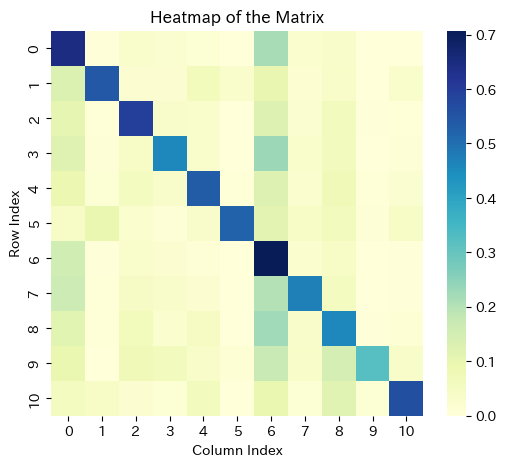


時点 7 から 8 への遷移行列:
各状態のエントロピー：[2.14787925 1.1151441  1.61945745 1.55708095 1.61274162 0.38342514
 2.14661527 1.38134674 1.98621437 0.49610509 0.83347877]

全体のエントロピー1.3890444311992225
      0     1     2     3     4     5     6     7     8     9     10
0  0.699 0.005 0.020 0.017 0.013 0.002 0.194 0.016 0.031 0.002 0.002
1  0.151 0.543 0.016 0.023 0.054 0.023 0.085 0.012 0.066 0.000 0.027
2  0.153 0.005 0.546 0.026 0.028 0.001 0.155 0.023 0.054 0.005 0.004
3  0.185 0.006 0.048 0.441 0.031 0.000 0.200 0.021 0.058 0.002 0.006
4  0.109 0.033 0.050 0.044 0.518 0.005 0.091 0.034 0.083 0.005 0.029
5  0.155 0.103 0.021 0.010 0.072 0.567 0.041 0.000 0.021 0.000 0.010
6  0.184 0.003 0.027 0.021 0.015 0.001 0.677 0.020 0.047 0.001 0.004
7  0.188 0.009 0.038 0.024 0.023 0.002 0.207 0.418 0.084 0.003 0.002
8  0.137 0.005 0.052 0.027 0.056 0.003 0.221 0.038 0.444 0.006 0.011
9  0.115 0.016 0.098 0.082 0.033 0.000 0.197 0.033 0.098 0.311 0.016
10 0.051 0.046 0.046 0.032 0.065 0.009 0.115 0.023 0.101 0

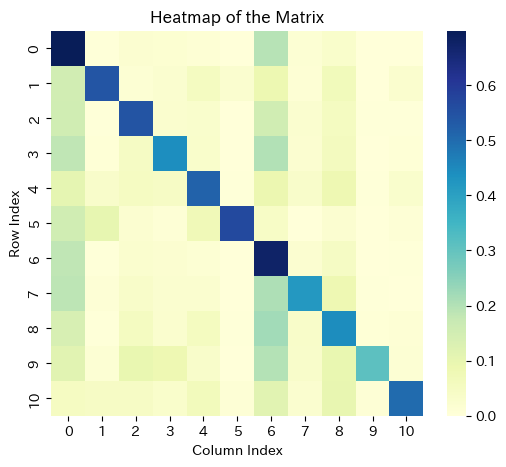


時点 8 から 9 への遷移行列:
各状態のエントロピー：[2.10564801 0.9336402  1.61732332 1.67972453 1.78291008 0.53211286
 2.13211961 1.52674852 2.01029733 0.65407877 0.9213898 ]

全体のエントロピー1.4450902741358345
      0     1     2     3     4     5     6     7     8     9     10
0  0.632 0.006 0.036 0.028 0.016 0.003 0.205 0.031 0.039 0.001 0.003
1  0.112 0.508 0.027 0.062 0.100 0.027 0.069 0.015 0.046 0.012 0.023
2  0.100 0.002 0.594 0.039 0.039 0.002 0.136 0.027 0.052 0.002 0.007
3  0.134 0.013 0.045 0.500 0.036 0.003 0.167 0.024 0.061 0.007 0.011
4  0.084 0.018 0.046 0.043 0.518 0.004 0.132 0.035 0.099 0.005 0.016
5  0.110 0.066 0.022 0.011 0.055 0.549 0.088 0.022 0.077 0.000 0.000
6  0.180 0.004 0.032 0.033 0.012 0.001 0.652 0.035 0.045 0.001 0.003
7  0.126 0.008 0.041 0.035 0.033 0.003 0.181 0.500 0.064 0.000 0.008
8  0.122 0.007 0.039 0.038 0.051 0.001 0.206 0.047 0.467 0.004 0.019
9  0.140 0.000 0.123 0.053 0.105 0.018 0.105 0.070 0.123 0.193 0.070
10 0.044 0.029 0.039 0.059 0.108 0.005 0.059 0.015 0.083 0

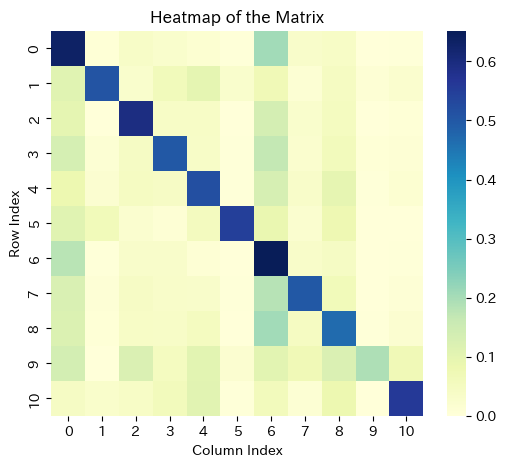


時点 9 から 10 への遷移行列:
各状態のエントロピー：[2.10324401 1.08304725 1.5065085  1.61471344 1.64696526 0.3479521
 2.18239905 1.28407277 1.98759779 0.82179888 1.00717141]

全体のエントロピー1.4168609513824217
      0     1     2     3     4     5     6     7     8     9     10
0  0.633 0.005 0.028 0.024 0.012 0.002 0.227 0.024 0.040 0.002 0.002
1  0.108 0.546 0.029 0.017 0.058 0.017 0.133 0.025 0.033 0.008 0.025
2  0.114 0.001 0.596 0.023 0.022 0.003 0.155 0.020 0.060 0.003 0.005
3  0.135 0.009 0.034 0.445 0.040 0.001 0.234 0.023 0.068 0.002 0.010
4  0.084 0.029 0.053 0.048 0.522 0.006 0.102 0.022 0.100 0.003 0.030
5  0.097 0.086 0.000 0.022 0.054 0.548 0.075 0.000 0.065 0.011 0.043
6  0.153 0.003 0.031 0.023 0.015 0.001 0.694 0.022 0.054 0.001 0.004
7  0.155 0.007 0.051 0.017 0.026 0.002 0.203 0.450 0.082 0.003 0.003
8  0.115 0.009 0.047 0.036 0.041 0.005 0.207 0.035 0.484 0.005 0.016
9  0.130 0.043 0.087 0.065 0.087 0.000 0.196 0.022 0.087 0.239 0.043
10 0.045 0.023 0.027 0.059 0.068 0.000 0.099 0.009 0.077 0

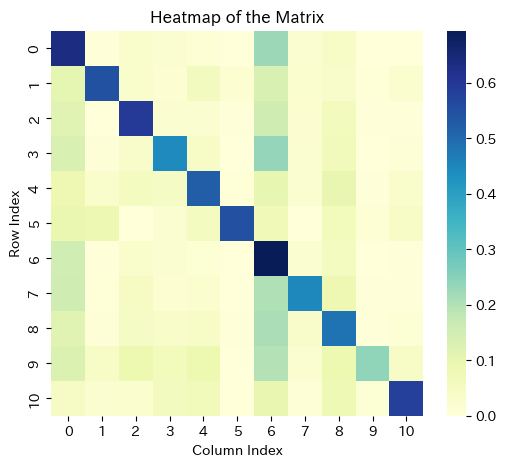


時点 10 から 11 への遷移行列:
各状態のエントロピー：[2.07913201 0.93434255 1.48700435 1.64259789 1.61159629 0.73560867
 2.18178911 1.52796173 1.99179862 0.76022714 0.83595775]

全体のエントロピー1.435274191257979
      0     1     2     3     4     5     6     7     8     9     10
0  0.623 0.008 0.036 0.026 0.018 0.002 0.219 0.028 0.036 0.001 0.002
1  0.080 0.576 0.025 0.017 0.092 0.042 0.071 0.013 0.071 0.004 0.008
2  0.093 0.004 0.596 0.037 0.029 0.003 0.147 0.025 0.058 0.004 0.006
3  0.122 0.017 0.030 0.481 0.045 0.002 0.194 0.034 0.063 0.004 0.007
4  0.070 0.025 0.040 0.043 0.543 0.004 0.135 0.039 0.072 0.003 0.027
5  0.129 0.086 0.022 0.022 0.000 0.581 0.108 0.011 0.043 0.000 0.000
6  0.136 0.004 0.033 0.027 0.017 0.002 0.698 0.026 0.053 0.001 0.004
7  0.119 0.015 0.041 0.045 0.040 0.003 0.228 0.452 0.051 0.001 0.006
8  0.115 0.008 0.045 0.038 0.052 0.005 0.218 0.034 0.467 0.008 0.009
9  0.122 0.000 0.041 0.061 0.061 0.061 0.204 0.041 0.122 0.224 0.061
10 0.054 0.008 0.029 0.046 0.088 0.004 0.105 0.033 0.092 

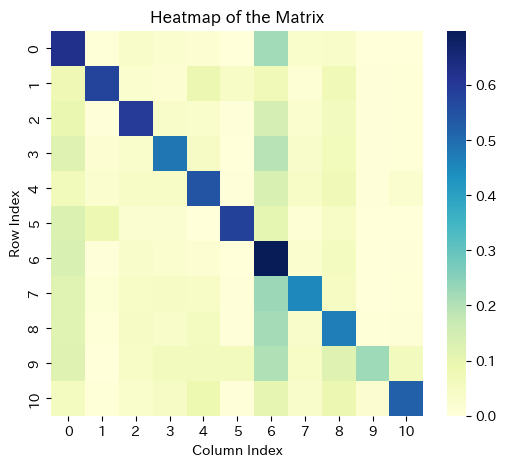

In [22]:
# 時点ごとの遷移行列を作成
import seaborn as sns
from scipy.stats import entropy
transition_matrices = create_time_dependent_transition_matrices(transtion_data)
# 時系列ごとのエントロピーを格納するリストを作成
each_ento_list=[]
# 全体のエントロピーを格納するためのリスト作成
all_ento_list=[]
# 結果の表示
for time, matrix in transition_matrices.items():
    print(f"\n時点 {time} から {time+1} への遷移行列:")
    print(f"各状態のエントロピー：{entropy(matrix)}")
    
    #各時点のエントロピーのリストを作成
    each_ento_list.append(entropy(matrix))
    print()
    print(f"全体のエントロピー{np.mean(entropy(matrix))}")
    
    #全体平均エントロピーのリストを作成
    all_ento_list.append(np.mean(entropy(matrix)))
    df_tra = pd.DataFrame(matrix).round(3)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)       # 出力の横幅を200文字に設定
    pd.set_option('display.float_format', '{:.3f}'.format)  # 小数点以下3桁表示
    print(df_tra)
   
    plt.figure(figsize=(6, 5))
    matrix = pd.DataFrame(matrix)
    sns.heatmap(df_tra, annot=False ,cmap='YlGnBu')
    plt.title('Heatmap of the Matrix')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    
    # ヒートマップの表示
    plt.show()

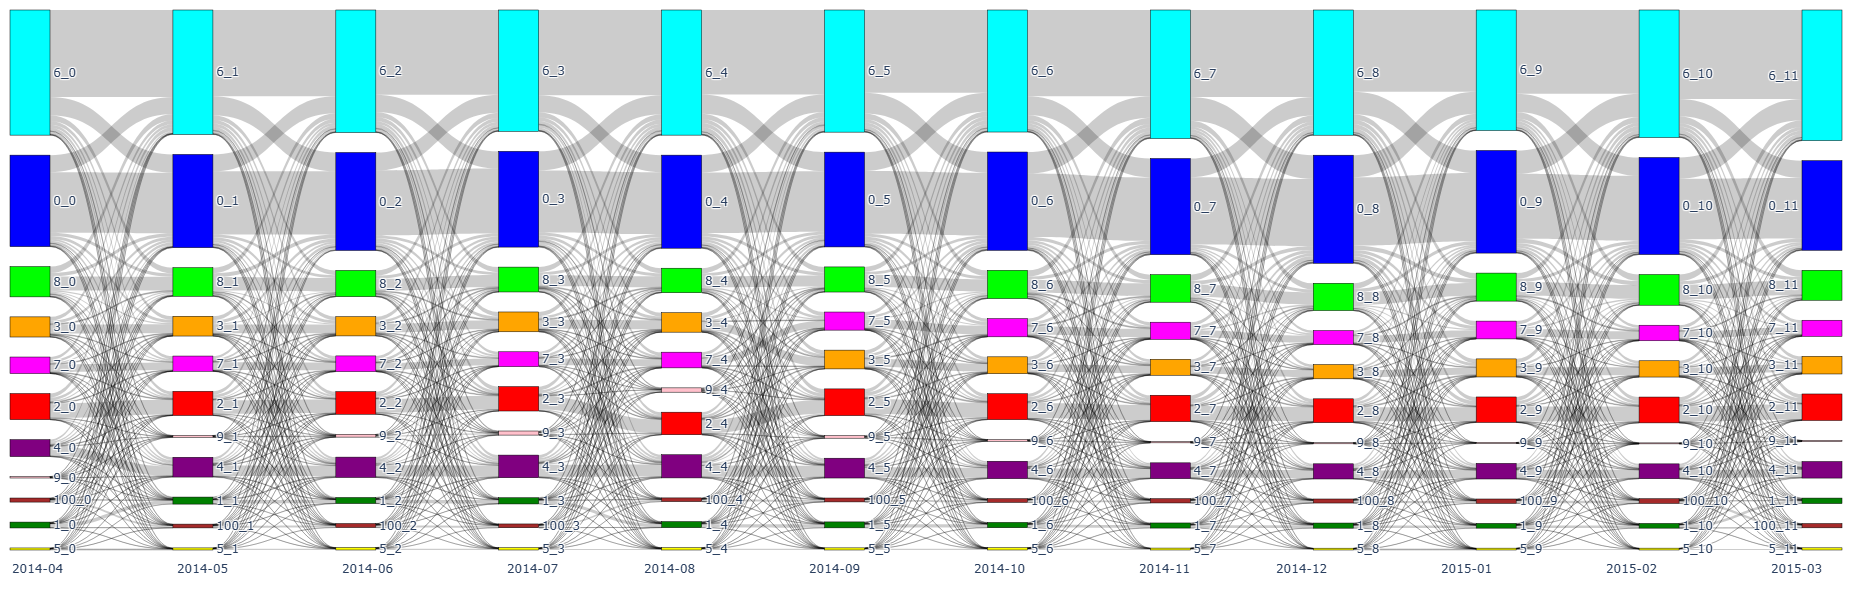

In [26]:
import pandas as pd
import plotly.graph_objects as go

def create_color_mapping():
    return {
        '0': 'blue', '1': 'green', '2': 'red', '3': 'orange',
        '4': 'purple', '5': 'yellow', '6': 'cyan', '7': 'magenta',
        '8': 'lime', '9': 'pink', '100':'brown'
    }

def prepare_sankey_data(source, target, values_list):
    unique_nodes = list(set(source + target))
    node_indices = {node: i for i, node in enumerate(unique_nodes)}

    color_mapping = create_color_mapping()
    color_list = [color_mapping[node.split('_')[0]] for node in unique_nodes]

    source_indices = [node_indices[node] for node in source]
    target_indices = [node_indices[node] for node in target]

    return unique_nodes, color_list, source_indices, target_indices

def create_sankey_diagram_with_dates(source, target, values_list, dates):
    unique_nodes, color_list, source_indices, target_indices = prepare_sankey_data(source, target, values_list)

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=40,
            line=dict(color="black", width=0.5),
            label=unique_nodes,
            color=color_list
        ),
        link=dict(
            source=source_indices,
            target=target_indices,
            value=values_list
        )
    )])

    # 各列に異なる年月を追加
    annotations = []
    for i, date in enumerate(column_dates):
        annotations.append(
            dict(
                text=date,  # 表示する年月
                x= i * 0.09,  # x軸を各列に対応（間隔を調整）
                y=-0.05,  # y軸の位置をグラフ上部に固定
                showarrow=False,
                font=dict(size=12),
                xref="paper",  # x座標を「描画エリア」で相対指定
                yref="paper"   # y座標を「描画エリア」で相対指定
            )
        )

    fig.update_layout(
        annotations=annotations,  # 全ての注釈を追加
        width=2000,
        height=600,
        margin=dict(l=10, r=10, t=10, b=50)  # 余白を調整
    )

    return fig


# 使用例
dates =pd.date_range(start="2014-04-01", end="2015-03-01", freq="MS").strftime("%Y-%m").tolist()
fig = create_sankey_diagram_with_dates(source, target, values_list, dates)

# 保存時の余白を最小化
fig.write_image("sankey_super.png", format="png", scale=2, width=2000, height=650)  # 余白を考慮したサイズ
fig.show()